# <b>Object Detection with Vertex AI AutoML</b>

## <b>Learning Objectives</b> ##

1. Learn how to create a managed dataset on Vertex AI for object detection
1. Learn how to train an AutoML object detection model on Vertex
1. Learn how to evaluate a model trained with AutoML on Vertex
1. Learn how to deploy a model trained with AutoML to a Vertex Endpoint
1. Learn how to predict on new data with deployed model


In this notebook we will use Vertex AI to train an AutoML model capable of detecting multiple objects in a given image and provide information about the objects and their location within the image.

We will start by creating a Managed Dataset on Vertex AI and importing a publicly available set of images into it. After that we will train, evaluate and deploy the AutoML model to a Vertex Endpoint. Finally we will send prediction requests to our model.

### Setup

In [2]:
import os
from datetime import datetime

from google.cloud import aiplatform

PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

os.environ["BUCKET"] = BUCKET
os.environ["PROJECT"] = PROJECT

aiplatform.init(project=PROJECT, location=REGION)

## Step 1: Prepare and Format Training Data

The first step in creating a Managed Datset on Vertex AI is to prepare the training data. In this case the training dataset is composed of images along with information identifying the location (through bounding boxes coordinates) and type of objects (through labels) in the images. 
Here are some constraints some general rules for preparing an Managed Datset for object detection:

* The following image formats are supported: JPEG, PNG, GIF, BMP, or ICO. Maximum file size is 30MB per image.

* It is recommended to have about 1000 training images per label (i.e. object type you want to detect in the images). For each label you must have at least 10 images, each with at least one annotation (bounding box and the label). In general, the more images per label you have the better your model will perform.

### Create a CSV file with image URIs and labels

Once your image files have been uploaded to a Cloud Storage bucket, you must create a CSV (or JSONL) file that lists the image URIs, along with bounding box information and the object labels. The CSV file will contain one row per bounding box in the image, so an image that has two bounding boxes will have two corresponding rows in the CSV file sharing the same image URI. 

In the example below, rows 1 and 2 reference the same image that has 2 annotations 
`(car,0.1,0.1,,,0.3,0.3,,)` and  `(bike,.7,.6,,,.8,.9,,)`. The first element of the annotation
is the object label in the bounding box, while the rest are the coordinates of the bounding box
within the image (see below for details).


Row 3 refers to an image that has only 1 annotation `(car,0.1,0.1,0.2,0.1,0.2,0.3,0.1,0.3)`, while row 4 references an image with no annotations.

The first column corresponds to the data split (this is optional - if not provided autoML will do a 80/10/10 split), the second column to the image URI, and the last columns hold the annotations. 

Bounding boxes can be in one of two formats:
- Containing 2 vertices (x,y coordinates of diagonally opposite points of the rectangle): `(x_min, y_min, , ,x_max,y_max,,)` OR
- Containing all 4 vertices`(x_min,y_min,x_max,ymin,x_max,y_max,x_min,y_max)`
**Example:**

```bash
TRAIN,gs://folder/image1.png,car,0.1,0.1,,,0.3,0.3,,
TRAIN,gs://folder/image1.png,bike,.7,.6,,,.8,.9,,
UNASSIGNED,gs://folder/im2.png,car,0.1,0.1,0.2,0.1,0.2,0.3,0.1,0.3
TEST,gs://folder/im3.png,,,,,,,,,
```

Each row above has these columns:

1. <b>Which dataset is the content in the row being assigned to.</b> - `TRAIN`, `VALIDATE`, `TEST` or `UNASSIGNED`
1. <b>What content is being annotated.</b> - It contains the GCS URI for the image
1. <b>A label that identifies how the object is categorized.
1. <b>A bounding box for an object in the image.</b>

For this lab, we will use a CSV that has already been created for us. The image URIs in the CSV point to publically avaliable images in GCS and contain annotations related to the foods/ingredients in each image.

Make sure the GCS bucket exists (if not then create it), then copy the CSV to your GCS bucket.

In [ ]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
   echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

In [ ]:
!gsutil cp ../dataset_import_files/salads.csv gs://{BUCKET}/

## Step 2: Create the Managed Dataset

Next step is to create a Managed Dataset on Vertex AI for object detection.
<br/>
**NOTE**: This can take between 5-10 minutes.

In [ ]:
DATASET_NAME = "salad_dataset"

ds = aiplatform.ImageDataset.create(
    display_name=DATASET_NAME,
    gcs_source=f"gs://{BUCKET}/salads.csv",
    import_schema_uri=aiplatform.schema.dataset.ioformat.image.bounding_box,
)

## Step 3: Train AutoML Model
Launch the training job. We will set the following parameters in `job.run()`
- `dataset`: The managed dataset we just created
- `model_display_name`: The display name of the model. The trained model will become a Vertex Model object after training is finished.
- `training_fraction_split`: Percentage of data to train on. Explicitly set to 0.8 (80%).
- `validation_fraction_split`: Percentage of data to validate on. Explicitly set to 0.1 (10%).
- `test_fraction_split`: Percentage of data to test on. Explicitly set to 0.1 (10%).
- `budget_milli_node_hours`: Milli-node hours for training job (e.g. 1000 means 1 node hour). Minimum for AutoML Object Detection training jobs is 20000 (20 node hours). 
- `disable_early_stopping`: Boolean. Explicitly set to False (i.e. Enable early stopping).  

In [ ]:
job = aiplatform.AutoMLImageTrainingJob(
    display_name="salad_" + TIMESTAMP, prediction_type="object_detection"
)

model = job.run(
    dataset=ds,
    model_display_name="salad",
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    budget_milli_node_hours=20000,
    disable_early_stopping=False,
)

**NOTE:** Model training can take between 1.5-2.5 hours to complete. You must wait for model to finish training before moving forward. 

Retreive the model resource and get the evaluation metrics. [Here](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is a good resource to learn more about evaluation metrics for object detection models. 

In [64]:
# Get model resources by display name
models = aiplatform.Model.list(filter="display_name=salad")
salad_model = models[0]

# Get model evaluation
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
model_service_client = aiplatform.gapic.ModelServiceClient(
    client_options=client_options
)

model_evaluations = model_service_client.list_model_evaluations(
    parent=salad_model.resource_name
)
evals = list(model_evaluations)[0]

for metric in list(evals.metrics["boundingBoxMetrics"]):
    print(f"Mean Average Precision (mAP): {metric['meanAveragePrecision']}")
    print(f"Intersection over union (IoU): {metric['iouThreshold']}\n")

Mean Average Precision (mAP): 0.43630856
Intersection over union (IoU): 0.35

Mean Average Precision (mAP): 0.4512489
Intersection over union (IoU): 0.25

Mean Average Precision (mAP): 0.37984547
Intersection over union (IoU): 0.6

Mean Average Precision (mAP): 0.46126723
Intersection over union (IoU): 0.2

Mean Average Precision (mAP): 0.014958993
Intersection over union (IoU): 0.9

Mean Average Precision (mAP): 0.5139509
Intersection over union (IoU): 0.05

Mean Average Precision (mAP): 0.48486522
Intersection over union (IoU): 0.1

Mean Average Precision (mAP): 0.21690094
Intersection over union (IoU): 0.8

Mean Average Precision (mAP): 0.39169085
Intersection over union (IoU): 0.55

Mean Average Precision (mAP): 0.431404
Intersection over union (IoU): 0.45

Mean Average Precision (mAP): 0.44135696
Intersection over union (IoU): 0.3

Mean Average Precision (mAP): 0.47103274
Intersection over union (IoU): 0.15

Mean Average Precision (mAP): 0.43488234
Intersection over union (IoU): 0

<br>

## <b>Step 6: Deploy the model</b> ##

Once we are happy with the performance of our trained model, we can deploy it so that it will be
available for predictions through an API. 

In [ ]:
endpoint = salad_model.deploy(
    deployed_model_display_name="salad_model_endpoint",
    traffic_split=None,
    min_replica_count=1,
    max_replica_count=1,
)

Creating Endpoint
Create Endpoint backing LRO: projects/693210680039/locations/us-central1/endpoints/4532565161692626944/operations/6281103728657301504
Endpoint created. Resource name: projects/693210680039/locations/us-central1/endpoints/4532565161692626944
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/693210680039/locations/us-central1/endpoints/4532565161692626944')
Deploying model to Endpoint : projects/693210680039/locations/us-central1/endpoints/4532565161692626944
Model does not support dedicated deployment resources. The machine_type, accelerator_type and accelerator_count parameters are ignored.
Deploy Endpoint model backing LRO: projects/693210680039/locations/us-central1/endpoints/4532565161692626944/operations/4335548689633247232


<br>

## <b>Step 7: Send prediction request</b> ##

In this example we will invoke an individual prediction from an image that is stored in our project's Cloud storage bucket.
Object detection models output many bounding boxes for an input image. For the output we are expecting that each box comes with:
1. a label and 
1. a score of confidence.


In [26]:
import base64

from google.cloud.aiplatform.gapic.schema import predict

TEST_IMAGE = "../test_images/salad.jpg"  # Replace with a Cloud storage bucket uploaded image of your choice

# Read the file.
with open(TEST_IMAGE, "rb") as f:
    file_content = f.read()

encoded_content = base64.b64encode(file_content).decode("utf-8")
instance = predict.instance.ImageObjectDetectionPredictionInstance(
    content=encoded_content
).to_value()

parameters = predict.params.ImageObjectDetectionPredictionParams(
    confidence_threshold=0.7
).to_value()

response = endpoint.predict(instances=[instance], parameters=parameters)
preds = response.predictions[0]
preds

{'bboxes': [[0.0, 0.587556541, 0.0944120884, 0.750312507],
  [0.3802149, 0.970372081, 0.283175915, 0.973080814]],
 'displayNames': ['Baked Goods', 'Salad'],
 'confidences': [0.930741429, 0.722414315],
 'ids': ['2157598605219725312', '284101160233598976']}

Now that we have the response object from the deployed model, we can inspect its predictions (i.e., the
bounding boxes and objects that the model has detected from the images we sent to it in the cell above):

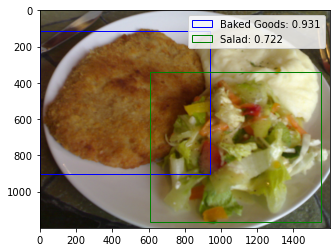

In [31]:
from itertools import cycle

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

# To generate a different colors for each label
cycol = cycle("bgrcmk")

img = Image.open(TEST_IMAGE)
fig, ax = plt.subplots()
ax.imshow(img)

for i in range(len(preds["displayNames"])):
    bbox = preds["bboxes"][i]
    display_name = preds["displayNames"][i]
    confidence = preds["confidences"][i]
    xy = (int(bbox[0] * img.width), int(bbox[2] * img.height))
    w = int(img.width * (bbox[1] - bbox[0]))
    h = int(img.height * (bbox[3] - bbox[2]))
    r = patches.Rectangle(
        xy,
        w,
        h,
        linewidth=1,
        facecolor="none",
        label=f"{display_name}: {confidence:.3f}",
        edgecolor=next(cycol),
    )
    ax.add_patch(r)

plt.legend()
plt.show()